In [355]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [356]:
apcodes = pd.read_csv(r'C:\Users\agadiraju\OneDrive - Alignment Healthcare\Desktop\CO\data\Airport_Codes.csv')
flights = pd.read_csv(r'C:\Users\agadiraju\OneDrive - Alignment Healthcare\Desktop\CO\data\flights.csv', low_memory=False)
tickets = pd.read_csv(r'C:\Users\agadiraju\OneDrive - Alignment Healthcare\Desktop\CO\data\tickets.csv')

In [357]:
myflights=flights
mytickets=tickets
#pd.set_option('display.max_rows', 500)

In [358]:
################################## Cleaning AirPort Codes Data ##################################
#apcodes.query('TYPE=="medium_airport" or TYPE=="large_airport"')['NAME'].count() #5146
#apcodes.query('TYPE=="medium_airport" or TYPE=="large_airport"')['IATA_CODE'].nunique() #4453
myapcodes=apcodes.query('(TYPE=="medium_airport" or TYPE=="large_airport") and ISO_COUNTRY=="US"')
myapcodes=myapcodes[myapcodes['IATA_CODE'].notna()]

myapcodesNA=apcodes[(apcodes['IATA_CODE'].isna()) & (apcodes['ISO_COUNTRY']=='US') 
        & ((apcodes['TYPE']=='medium_airport') | (apcodes['TYPE']=='large_airport'))]
myapcodesNA=myapcodesNA[~myapcodesNA.duplicated()] #Making sure to remove dups


myapcodes[myapcodes.duplicated('IATA_CODE')] #dups check
myapcodes=myapcodes[~myapcodes.NAME.str.contains("Duplicate")]
myapcodes=myapcodes[~myapcodes.duplicated()] # Remove dups 



C:\Users\agadiraju\AppData\Local\Temp\ipykernel_7240\2431337736.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  myflights['DISTANCE_New'] = myflights['DISTANCE'].replace(['Hundred', '****','Twenty','nan','NAN'], [100, 0,20,0,0]).astype(float)


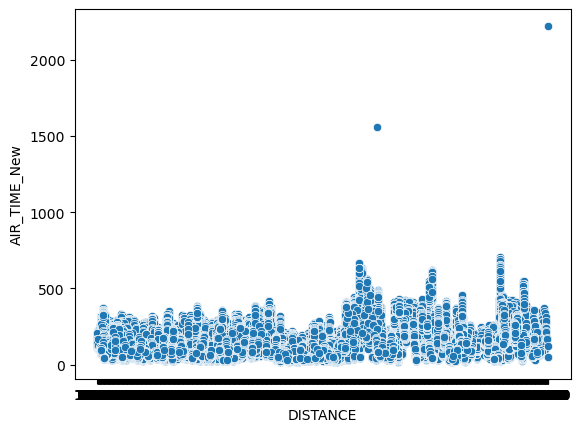

In [359]:
################################## Cleaning Flights Data ##################################

myflights['AIR_TIME_New'] = myflights['AIR_TIME'].replace(['$$$','Two'], [0,2]).astype(float)
sns.scatterplot(data=myflights_airport, y="AIR_TIME_New", x="DISTANCE") # Distnce vs time scatter plot below

myflights=myflights[~myflights.duplicated()] # Remove duplicates #1915886 after dedup 1911341
myflights['DISTANCE_New'] = myflights['DISTANCE'].replace(['Hundred', '****','Twenty','nan','NAN'], [100, 0,20,0,0]).astype(float)
myflights=myflights.query('DISTANCE_New >125')  # Assuming minimum distance between cities to operate # 1851774

myflights['AvgSpeed']= myflights['DISTANCE_New']/(myflights['AIR_TIME_New']/60)
myflights=myflights.query('AvgSpeed <1000')  # Assuming the avg speed is <1000m/hr

myflights=myflights[myflights['CANCELLED']==0] # Filtered calcelled flights # 1802506
myflights=myflights[(myflights['ARR_DELAY'].notna()) | (myflights['AIR_TIME'].notna())] # removing missing flight data # 1798237

myflights['ISSUE_FLAG']=0 #myflights['ISSUE_FLAG'].astype(int)
myflights['TripIdentifier']=myflights['ORIGIN']+"-"+myflights['DESTINATION']
myflights['OCCUPANCY']=myflights['OCCUPANCY_RATE']*200

myflights['FL_DATE_New']= pd.to_datetime(myflights['FL_DATE'])

#flights[flights['OP_CARRIER_FL_NUM']=='ARD'] #ACA distance too long, DDD,YUD,ARD airtime too small

myflights['ISSUE_FLAG'] = np.where((myflights['OP_CARRIER_FL_NUM'] == 'ARD') 
        | (myflights['OP_CARRIER_FL_NUM'] == 'DDD') | (myflights['OP_CARRIER_FL_NUM'] == 'YUD') 
        | (myflights['OP_CARRIER_FL_NUM'] == 'ACA'),1,myflights['ISSUE_FLAG'])



myflights['FOMC_Cost']=myflights['DISTANCE_New']*8
myflights['DIO_Cost']=myflights['DISTANCE_New']*1.18

myflights['DELAY_COST']=np.where(myflights['DEP_DELAY']>15,(myflights['DEP_DELAY']-15)*75,0)
myflights['Baggage']=myflights['OCCUPANCY']*0.5*70 # For round trips only use caution



In [361]:
################################## Merging ##################################

myflights_airport=myflights.merge(myapcodes[['TYPE','IATA_CODE']], how='left', left_on='ORIGIN',right_on='IATA_CODE')
myflights_airport=myflights_airport.rename(columns={'TYPE': 'ORI_TYPE', 'IATA_CODE': 'ORI_CODE'})

myflights_airport=myflights_airport.merge(myapcodes[['TYPE','IATA_CODE']], how='left', left_on='DESTINATION',right_on='IATA_CODE')
myflights_airport=myflights_airport.rename(columns={'TYPE': 'DES_TYPE', 'IATA_CODE': 'DES_CODE'})


myflights_airport['ORI_CODE'].isna().sum() # 16757
myflights_airport['DES_CODE'].isna().sum() # 16752
#myflights_airport[(myflights_airport['ORI_TYPE'].isna()) | (myflights_airport['DES_TYPE'].isna())] # 32745 

#Assuming $7,500 as Ope cost for airports with missing IATA_CODE
myflights_airport['AIR_COST']=np.where(myflights_airport['DES_TYPE']=='medium_airport',5000,
                              np.where(myflights_airport['DES_TYPE']=='large_airport',10000, 
                               np.where(myflights_airport['DES_TYPE'].isna(),7500,0 )))

myflights_airport['OPE_COST']=myflights_airport['FOMC_Cost']+myflights_airport['DIO_Cost']+myflights_airport['DELAY_COST']+myflights_airport['AIR_COST']

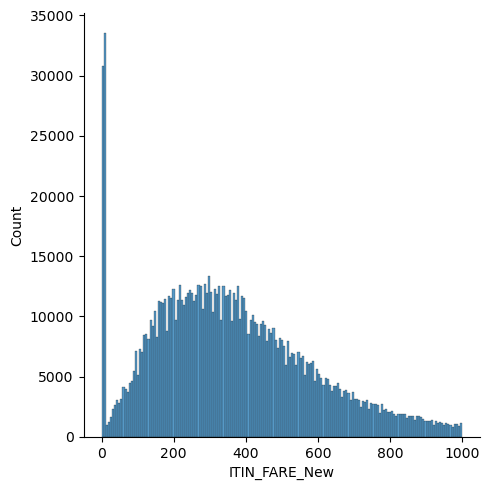

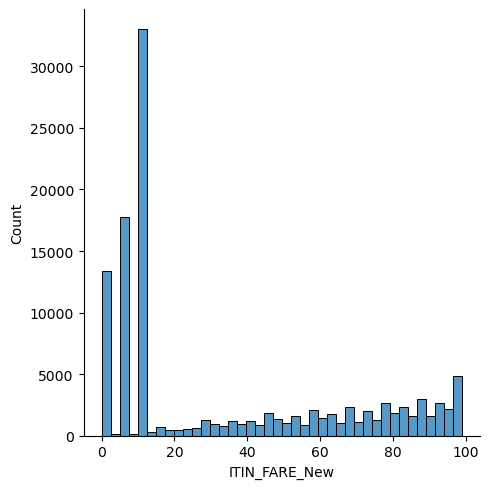

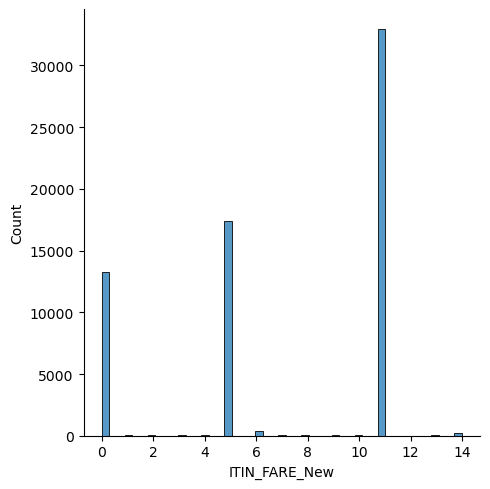

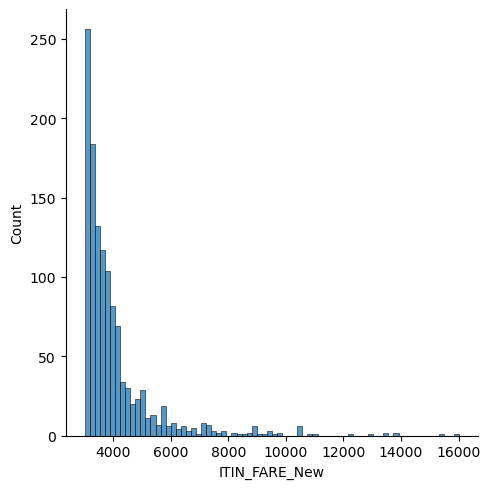

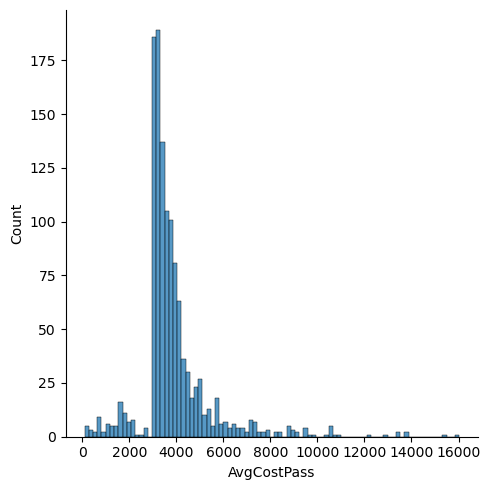

In [362]:
################################## Cleaning Tickets Data ##################################

mytickets['ITIN_FARE_New']=mytickets['ITIN_FARE'].astype(str).str.extractall('(\d+).').unstack().fillna('').sum(axis=1).astype(int)
mytickets['AvgCostPass']=mytickets['ITIN_FARE_New']/mytickets['PASSENGERS']

sns.displot(data=mytickets[mytickets['ITIN_FARE_New']<1000], x="ITIN_FARE_New")
sns.displot(data=mytickets[mytickets['ITIN_FARE_New']<100], x="ITIN_FARE_New")
sns.displot(data=mytickets[mytickets['ITIN_FARE_New']<15], x="ITIN_FARE_New")

out=mytickets.query('ITIN_FARE_New>3000 and ITIN_FARE_New<27000')
sns.displot(data=out, x="ITIN_FARE_New")
sns.displot(data=out, x="AvgCostPass")


mytickets.count() #1167285
mytickets=mytickets[~mytickets.duplicated()] #revoved dups # 1093812
mytickets.isna().sum()
#print(mytickets[mytickets['PASSENGERS'].isna()]['PASSENGERS'].count()/tickets['PASSENGERS'].count()*100) #0.16% pass missing data
mytickets=mytickets[mytickets['PASSENGERS'].notna()] #Removing 0.16% of data with missing pass data # 1165308

#Based on United Airlines policy, you can book up to eight travelers at a time on united.com. Below link for reference
#https://www.united.com/ual/en/us/fly/help/faq/flight-reservations.html
mytickets=mytickets.query('PASSENGERS<=8')

mytickets['TripIdentifier']=mytickets['ORIGIN']+"-"+mytickets['DESTINATION']

# Filled the fare value using mean
mytickets[mytickets['ITIN_FARE'].isna()].count()/tickets['PASSENGERS'].count()*100 #0.08% ITIN_FARE missing data
mytickets['ITIN_FARE_New'].fillna((mytickets['ITIN_FARE_New'].mean()), inplace=True)

#Assuming the cost for flight is atleast $20 per passanger. Filtering the data
mytickets=mytickets.query('AvgCostPass>20 and AvgCostPass<27000')




In [363]:
###### 1. Top 10 Routes by no. of Flights ##################################

routes=myflights_airport.groupby(['ORIGIN','DESTINATION']).size().reset_index(name='count')
routes.sort_values(by=['count'], ascending=False)

top10=routes.merge(routes, how='inner', left_on=['ORIGIN','DESTINATION'],right_on=['DESTINATION','ORIGIN'])

top10['Flights']=top10[['count_x','count_y']].min(axis=1)
top10.sort_values(by=['Flights','ORIGIN_x'], ascending=False)
top10['Ranks']=top10.groupby(['Flights']).cumcount()+1
top10=top10[top10['Ranks']==1].sort_values(by=['Flights','ORIGIN_x'], ascending=False)
top10=top10.drop(columns=['count_x', 'ORIGIN_y','DESTINATION_y','count_y','Ranks'])
top10[0:10] # Top 10 round trip flights by no. of flights

,ORIGIN_x,DESTINATION_x,Flights
2922,LAX,SFO,4158
3027,LGA,ORD,3571
2784,LAS,LAX,3252
2666,JFK,LAX,3140
2921,LAX,SEA,2494
582,BOS,LGA,2402
4141,PDX,SEA,2375
196,ATL,MCO,2351
192,ATL,LGA,2292
162,ATL,FLL,2289


In [364]:
###### 2. Top 10 Profitable Routes ##################################


cost=myflights_airport.groupby(['OP_CARRIER','ORIGIN','DESTINATION']).aggregate({'OPE_COST':'sum','Baggage': 'sum'}).reset_index().sort_values(by=['OPE_COST'], ascending=False)

OPE_BAG_COST=cost.merge(cost, how='inner', left_on=['OP_CARRIER','ORIGIN','DESTINATION'],right_on=['OP_CARRIER','DESTINATION','ORIGIN'])
#roundtripcost=myflights.rename(columns={'TYPE': 'DES_TYPE', 'IATA_CODE': 'DES_CODE'})
OPE_BAG_COST['OPE_COST_TOT']=OPE_BAG_COST[['OPE_COST_x','OPE_COST_y']].sum(axis=1)
OPE_BAG_COST['BAG_TOT']=OPE_BAG_COST[['Baggage_x','Baggage_y']].sum(axis=1)

#OPE_BAG_COST.sort_values(by=['OPE_COST_TOT','ORIGIN_x'], ascending=False)
OPE_BAG_COST['Ranks']=OPE_BAG_COST.groupby(['OP_CARRIER','OPE_COST_TOT']).cumcount()+1
OPE_BAG_COST=OPE_BAG_COST[OPE_BAG_COST['Ranks']==1].sort_values(by=['OPE_COST_TOT','ORIGIN_x'], ascending=False)
OPE_BAG_COST=OPE_BAG_COST.drop(columns=['OPE_COST_x', 'Baggage_x','ORIGIN_y','DESTINATION_y','OPE_COST_y','Baggage_y','Ranks'])



ticcost=mytickets[mytickets['ROUNDTRIP']==1].groupby(['REPORTING_CARRIER','ORIGIN','DESTINATION']).aggregate({'ITIN_FARE_New':'sum','PASSENGERS':'sum'}).sort_values(by=['ITIN_FARE_New'], ascending=False).reset_index()
TIC_COST_TOT=ticcost.merge(ticcost, how='inner', left_on=['REPORTING_CARRIER','ORIGIN','DESTINATION'],right_on=['REPORTING_CARRIER','DESTINATION','ORIGIN'])
TIC_COST_TOT['TRIPCOST']=TIC_COST_TOT[['ITIN_FARE_New_x','ITIN_FARE_New_y']].sum(axis=1)

TIC_COST_TOT.sort_values(by=['TRIPCOST','ORIGIN_x'], ascending=False)
TIC_COST_TOT['Ranks']=TIC_COST_TOT.groupby(['REPORTING_CARRIER','TRIPCOST']).cumcount()+1
TIC_COST_TOT=TIC_COST_TOT[TIC_COST_TOT['Ranks']==1].sort_values(by=['TRIPCOST','ORIGIN_x'], ascending=False)
TIC_COST_TOT=TIC_COST_TOT.drop(columns=['ITIN_FARE_New_x','ITIN_FARE_New_y', 'ORIGIN_y','DESTINATION_y','Ranks'])
TIC_COST_TOT[0:10] # Top 10 round trip flights by no. of flights 



PL=OPE_BAG_COST.merge(TIC_COST_TOT, how='inner', left_on=['OP_CARRIER','ORIGIN_x','DESTINATION_x'],right_on=['REPORTING_CARRIER','ORIGIN_x','DESTINATION_x'])
PL['ProfitLoss']=round((PL['BAG_TOT']+PL['TRIPCOST'])-PL['OPE_COST_TOT'],0)
PL.round(0)
PL.groupby(['ORIGIN_x','DESTINATION_x']).aggregate({'OPE_COST_TOT':'sum','BAG_TOT':'sum','TRIPCOST':'sum','ProfitLoss':'sum'}).sort_values(by=['ProfitLoss']).reset_index()



,ORIGIN_x,DESTINATION_x,OPE_COST_TOT,BAG_TOT,TRIPCOST,ProfitLoss
0,EWR,SFO,68600085.30,8945300.0,1069838.0,-58584947.0
1,ORD,SFO,68796275.72,10949680.0,489532.0,-57357064.0
2,EWR,LAX,55185259.76,7543550.0,559916.0,-47081794.0
3,ATL,LGA,61099047.16,15697500.0,355542.0,-45046005.0
4,DFW,LGA,48269748.14,9410590.0,202982.0,-38656176.0
...,...,...,...,...,...,...
1895,OAK,TUS,67654.84,16730.0,17239.0,-33686.0
1896,IAH,RIC,41242.52,9800.0,4675.0,-26768.0
1897,ABQ,SFO,36450.56,7630.0,2200.0,-26621.0
1898,IAH,RNO,48090.80,9310.0,14009.0,-24772.0


<AxesSubplot:xlabel='AvgCostPass', ylabel='REPORTING_CARRIER'>

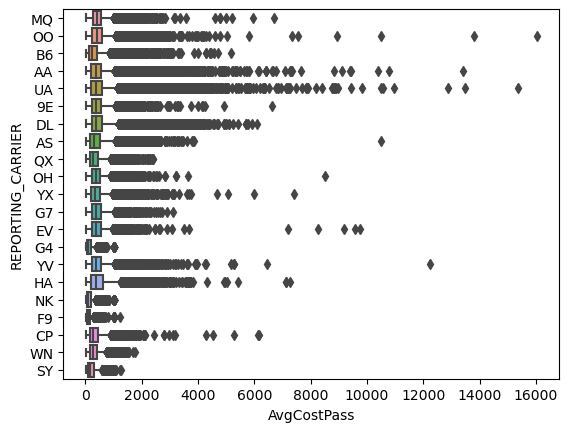

In [365]:
sns.boxplot(data=mytickets, x="AvgCostPass", y="REPORTING_CARRIER")

In [366]:
mytickets['ITIN_FARE_New'].mean()

438.6550423137231

In [367]:
################################## Some Stats ##################################

print('% of Flights data filtered', round((1-myflights['FL_DATE'].count()/flights['FL_DATE'].count())*100,2),'%')


print('% of itineraries with Passangers >=10 are', round( (mytickets[mytickets['PASSENGERS']>=10].count()['PASSENGERS'] 
                                                  / mytickets['PASSENGERS'].count())*100,2),'%')

% of Flights data filtered 6.15 %
% of itineraries with Passangers >=10 are 0.0 %


In [368]:
############   Validation Examples   ############
#tickets[tickets['ITIN_ID']==201915871] # multiple and repeating dest infor for same iter id
#tickets[tickets['ITIN_ID']==201912545927] #org - dest is 1300 miles and fair seems like error
#tickets[tickets['ITIN_ID']==201913235979] # dup and too expensive $377K
#tickets[tickets['ITIN_ID']==201913236036] # dup and too expensive $375K
tickets[tickets['ITIN_ID']==201913394818] # single ticket $38K

tickets[tickets['ITIN_FARE']=='820$$$'] # has string values itin id = 201913102587

mytickets[mytickets['PASSENGERS']==180]


myapcodes[myapcodes['IATA_CODE']=='JNB']  # duplicates

myapcodes[myapcodes['IATA_CODE'].notna()]['ISO_COUNTRY'].unique()

myflights[(myflights['OP_CARRIER_FL_NUM']=='3223') & (myflights['FL_DATE']=='3/2/19')] #Dups in data


#myflights[myflights['AIR_TIME'].isna()].iloc[:,-20:]
myflights[(myflights['ARR_DELAY'].isna()) | (myflights['AIR_TIME'].isna())].count()


FL_DATE              0
OP_CARRIER           0
TAIL_NUM             0
OP_CARRIER_FL_NUM    0
ORIGIN_AIRPORT_ID    0
ORIGIN               0
ORIGIN_CITY_NAME     0
DEST_AIRPORT_ID      0
DESTINATION          0
DEST_CITY_NAME       0
DEP_DELAY            0
ARR_DELAY            0
CANCELLED            0
AIR_TIME             0
DISTANCE             0
OCCUPANCY_RATE       0
AIR_TIME_New         0
DISTANCE_New         0
AvgSpeed             0
ISSUE_FLAG           0
TripIdentifier       0
OCCUPANCY            0
FL_DATE_New          0
FOMC_Cost            0
DIO_Cost             0
DELAY_COST           0
Baggage              0
dtype: int64

In [372]:
#################### Summary & Recommendations ###############

print('Summary:')
print('Top 10 flight routes are')
print(top10[0:10])

print('\n')
print('Top 10 profitable routes are')
print(PL[0:10])



print("""
Recommendations:
Pick the routes which are busiest and highly profitable.
Also, routes which are busy but slowly picking up the passanger volume. These might have good opprtunity to grow in future.
Few aspects that can be analyzed are:
Look at average cost/passanger by carrier
Alayze passanger volume by route
Avg accupancy by route
air time vs distnace tradeoff to further filter data""")

print('\n')
print("""
KPIs to consider:
Total revenue, profit by carrier or route
On-time performance for routes
Passanger satisfaction
Avg. cot per passanger for route by carrier to see if particular carrier offers better price overall
Frequency of external factors like weather impact on on-time arrival/delay by routes


""")

Summary:
Top 10 flight routes are
     ORIGIN_x DESTINATION_x  Flights
2922      LAX           SFO     4158
3027      LGA           ORD     3571
2784      LAS           LAX     3252
2666      JFK           LAX     3140
2921      LAX           SEA     2494
582       BOS           LGA     2402
4141      PDX           SEA     2375
196       ATL           MCO     2351
192       ATL           LGA     2292
162       ATL           FLL     2289


Top 10 profitable routes are
  OP_CARRIER ORIGIN_x DESTINATION_x  OPE_COST_TOT     BAG_TOT  \
0         UA      EWR           SFO   68600085.30   8945300.0   
1         UA      EWR           LAX   55185259.76   7543550.0   
2         DL      ATL           LGA   46205427.28  11837840.0   
3         UA      ORD           SFO   46143083.12   7269010.0   
4         AA      DFW           LGA   44271998.72   8640380.0   
5         AA      LAX           MIA   43793477.04   6207600.0   
6         AS      SEA           LAX   43630583.60  10333540.0   
7       

In [370]:
#################### Improvements ##################
#Calculate breakeven cost based on airplne cost and profitability over time. Being able to measure how many months or years it takes for the cost to break even.
#Calulate routes which are on-time most of the time.
#The operational cost seems high. One aspect in the data to be addressed is to restrict one airplane to a round trip.
#Distance vs Air_Time seems off. Both large & short distances seem to have clustered towards the bottom of the graph. Needs more analysis.
#There is huge scope for visualizing the data by various metrics. Given more time I can do better analysis by spending more time on the data 